# Homework 1: Montecarlo and TD methods

Let's implement these methods for a simple toy case with discrete and action spaces.

- Implement First-visit Montecarlo for Frozen lake (1p)
- Implement Sarsa and Q-Learning for (1p each)
- How does the value function V look for the different Q functions you found above? You can look at tutorial 3 for ideas how to do this plot. (1p) 

The code below can help you get started with TD. For inspiration about Montecarlo, look at tutorial 3.


In [2]:
import numpy as np
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
env = gym.make("FrozenLake-v0")

In [4]:
print("Number of states =", env.observation_space.n)
print("Number of actions =", env.action_space.n)

Number of states = 16
Number of actions = 4


In [13]:
def epsilon_greedy_policy(Q, epsilon, actions):
    """ 
    Q is a numpy array = qualities of (state, action) pairs, 
    epsilon = prob to choose random action
    1 - eps = prob to choose the action with best Q value = argmax(Q[s][:])
    actions = list of actions
    """
    
    def policy_fn(state):
        if np.random.rand()>epsilon:
            if np.max(Q[state][:]) == 0:
                action = np.random.choice(actions)
            else:
                action = np.argmax(Q[state][:])
        else:
            action = np.random.choice(actions)
        return action
    
    return policy_fn

### First-visit Montecarlo

In [18]:
def run_episode(env, policy): 
    done = False
    state = env.reset()
    episode = []
    while not done:
        action = policy(state)
        new_state, reward, done, _ = env.step(action)
        episode.append((state,action,reward))
        state = new_state    
    return episode # returns list of (state,action,reward)

n_iter = 10000
gamma = 0.99 # discount factor
total_episode_rewards = []

Q = np.zeros([env.observation_space.n, env.action_space.n]) # Q function
R = defaultdict(lambda: np.zeros(env.action_space.n)) # Sum of first-visit rewards of a certain (state, action)
N = defaultdict(lambda: np.zeros(env.action_space.n)) # Number of first-visits of a certain (state, action)
actions = range(env.action_space.n)

for j in tqdm(range(n_iter)):
    # Play 100 episodes randomly, then slowly reduce the randomness
    policy = epsilon_greedy_policy(Q, epsilon=100./(j+1), actions = actions ) 
    
    episode = run_episode(env, policy) # run till losing
    
    ep_reward = sum(x[2]*(gamma**i) for i, x in enumerate(episode)) # episode = list of (state,action,reward)
    #if ep_reward > 0:
    #    print(j, "reward =", ep_reward, "episode=", episode)
    total_episode_rewards.append(ep_reward) # only for logging
    
    # each move in a episode is converted to a tuple of (state, action) to use as dict key
    sa_in_episode = set([(x[0],x[1]) for x in episode]) 
    
    # Find first visit of each (state,action) in the episode
    for s,a in sa_in_episode:
        first_visit = next(i for i,x in enumerate(episode) if x[0]==s and x[1]==a)
        
        G = sum(x[2]*(gamma**i) for i, x in enumerate(episode[first_visit:])) # calc reward from this (s,a) till the end of the episode
        
        R[s][a] += G
        N[s][a] += 1
        Q[s][a] += R[s][a]/N[s][a] # update Q-function

100%|██████████| 10000/10000 [00:02<00:00, 4630.49it/s]


In [21]:
arr = np.array(range(16))
arr.reshape(4,4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [24]:
print("Q =\n", Q)
print("Q argmax =\n", np.argmax(Q, axis=1))

Q =
 [[8.49042506e+00 5.53557835e+02 3.57076677e+00 5.38038700e+00]
 [6.70830213e-01 2.31774160e+02 2.28285155e+00 2.61740932e+00]
 [1.93833822e+02 2.02316375e+00 1.41971799e+00 1.32529349e+00]
 [0.00000000e+00 2.15323396e+00 0.00000000e+00 0.00000000e+00]
 [3.90400085e+00 4.11627925e+02 1.03955934e+00 2.31312623e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.46335826e+00 3.37065424e+00 2.21488991e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.54748983e-01 4.26108892e+02 2.56800008e+00 2.66573424e+00]
 [2.52746602e+00 3.46156425e+00 4.97976708e+02 4.14104417e+00]
 [4.28059950e+02 4.83739200e+00 4.39541188e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.66110676e+00 5.33849473e+00 3.98393241e+02 7.37811872e-01]
 [3.95840300e+00 6.50215233e+02 8.27120711e+00 2.30918329e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0

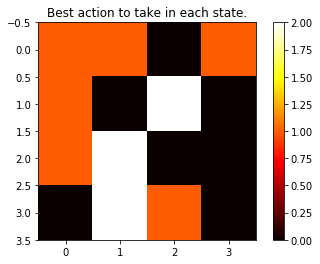

In [28]:
plt.imshow(np.argmax(Q, axis=1).reshape(4,4), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Best action to take in each state.")
plt.show()

In [3]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
actions = range(env.action_space.n)
score = [] 

gamma = 0.99 # discount factor
alpha = 0.1  # 
n_episodes = 100
 
for j in range(n_episodes):
    done = False
    state = env.reset()
    
    # Play randomly 10 episodes, then reduce slowly the randomness
    policy = epsilon_greedy_policy(Q, epsilon=10./(j+1), actions = actions ) 
    
    
    ### Generate sample episode
    t=0
    while not done:
        t+=1
        action = policy(state)    
        new_state, reward, done, _ =  env.step(action)
        new_action = policy(new_state)
        
        #Book-keeping
        if done:
            # YOUR CODE GOES HERE
            pass
        else:
            # YOUR CODE GOES HERE
            pass
            
        state, action = new_state, new_action
            
        if done:
            if len(score) < 100:
                score.append(reward)
            else:
                score[j % 100] = reward
                
                
            if (j+1)%1000 == 0:
                print("INFO: Episode {} finished after {} timesteps with r={}. \
                Running score: {}".format(j+1, t, reward, np.mean(score)))
            



[2018-03-06 08:21:11,952] Making new env: FrozenLake-v0


In [ ]:
env.close()